<a href="https://colab.research.google.com/github/HSE-LAMBDA/mldm-2019/blob/master/day-7/GAN_(WGAN_GP_%2B_conv).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://github.com/yandexdataschool/MLatImperial2019/raw/master/06_lab/lfw_dataset.py

In [0]:
!pip install scipy==1.1

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import numpy as np
import tensorflow as tf
tf.__version__

'2.0.0'

In [0]:
from lfw_dataset import fetch_lfw_dataset
data, _ = fetch_lfw_dataset(dimx=36, dimy=36)

In [4]:
data.shape

(13143, 36, 36, 3)

In [0]:
import matplotlib.pyplot as plt

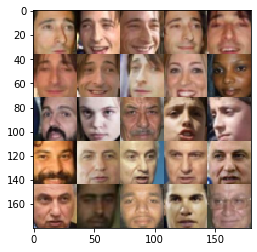

In [6]:
plt.imshow(data[100:125].reshape(5, 5, 36, 36, 3).transpose((0, 2, 1, 3, 4)).reshape(5 * 36, 5 * 36, 3));

In [7]:
data.dtype, data.max()

(dtype('uint8'), 255)

In [8]:
X_train = data.astype('float32') / 255
print(X_train.min(), X_train.max(), X_train.dtype)

0.0 1.0 float32


In [14]:
ll = tf.keras.layers

LATENT_DIM = 32

generator = tf.keras.Sequential([
  ll.Dense(32, activation='relu', input_shape=(LATENT_DIM,)),
  ll.Reshape((2, 2, 8)),

  ll.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
  
  ll.UpSampling2D(), # 4x4
  ll.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),

  ll.UpSampling2D(), # 8x8
  ll.Conv2D(filters=8, kernel_size=3, padding='valid', activation='relu'), # 6x6

  ll.UpSampling2D(), # 12x12
  ll.Conv2D(filters=8, kernel_size=3, padding='valid', activation='relu'), # 10x10

  ll.UpSampling2D(), # 20x20
  ll.Conv2D(filters=8, kernel_size=3, padding='valid', activation='relu'), # 18x18

  ll.UpSampling2D(), # 36x36
  ll.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
  ll.Conv2D(filters=3, kernel_size=1, padding='same', activation='sigmoid')

  # ll.Dense(32, input_shape=(LATENT_DIM,), activation='relu'),
  # ll.Dense(64, activation='relu'),
  # ll.Dense(36 * 36 * 3, activation='sigmoid'),
  # ll.Reshape((36, 36, 3)),
])

discriminator = tf.keras.Sequential([
  ll.Conv2D(filters=4, kernel_size=3, padding='same', input_shape=(36, 36, 3)),
  ll.ReLU(),
  ll.Dropout(0.1),
  ll.MaxPool2D(), # 18x18

  ll.Conv2D(filters=8, kernel_size=3, padding='valid'), # 16x16
  ll.ReLU(),
  ll.Dropout(0.1),
  ll.MaxPool2D(), # 8x8

  ll.Conv2D(filters=16, kernel_size=3, padding='same'),
  ll.ReLU(),
  ll.Dropout(0.1),
  ll.MaxPool2D(), # 4x4

  ll.Conv2D(filters=16, kernel_size=3, padding='same'),
  ll.ReLU(),
  ll.Dropout(0.1),
  ll.MaxPool2D(), # 2x2

  ll.Conv2D(filters=32, kernel_size=3, padding='same'),
  ll.ReLU(),
  ll.Dropout(0.1),
  ll.MaxPool2D(), # 1x1

  ll.Reshape((32,)),
  ll.Dense(8),
  ll.ReLU(),
  ll.Dropout(0.1),

  ll.Dense(1)

  # ll.Reshape((36 * 36 * 3,), input_shape=(36, 36, 3)),
  # ll.Dense(64, activation='relu'),
  # ll.Dropout(0.1),
  # ll.Dense(32, activation='relu'),
  # ll.Dropout(0.1),
  # ll.Dense(1),
])

generator.summary()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
reshape_2 (Reshape)          (None, 2, 2, 8)           0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 2, 32)          2336      
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 16)          4624      
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 6, 8)          

In [0]:
def gen_images(num):
  return generator(tf.random.normal(shape=(num, LATENT_DIM)))

# @tf.function decorator below compiles the function
# it decorates into a static graph. This improves the performance
# but there are some pitfalls one should be aware of when using it,
# check out https://www.tensorflow.org/tutorials/customization/performance
# for more details
@tf.function
def forward(batch, with_GP):
  real = batch
  fake = gen_images(len(batch))

  loss = tf.reduce_mean(discriminator(fake) - discriminator(real))

  if with_GP:
    alpha = tf.random.uniform(shape=(len(batch), 1, 1, 1))
    interpolates = alpha * real + (1. - alpha) * fake
    with tf.GradientTape() as t:
      t.watch(interpolates)
      int_output = discriminator(interpolates)
    grads = tf.reshape(t.gradient(int_output, interpolates), (len(batch), -1))
    penalty = tf.reduce_mean(tf.maximum(0., tf.norm(grads, axis=1) - 1)**2)
    return loss, penalty
  return loss

opt_d = tf.optimizers.RMSprop(0.003)
opt_g = tf.optimizers.RMSprop(0.003)
GP_FACTOR = 10.


@tf.function
def disc_step(batch):
  with tf.GradientTape() as t:
    loss, penalty = forward(batch, True)
    d_loss = loss + GP_FACTOR * penalty
  grads = t.gradient(d_loss, discriminator.trainable_variables)
  opt_d.apply_gradients(zip(grads, discriminator.trainable_variables))
  
  return loss



@tf.function
def gen_step(batch):
  with tf.GradientTape() as t:
    g_loss = -forward(batch, False)
  grads = t.gradient(g_loss, generator.trainable_variables)
  opt_g.apply_gradients(zip(grads, generator.trainable_variables))
  return g_loss


In [0]:
from IPython.display import clear_output
from tqdm import trange

In [0]:
try:
  del losses
  del i_ep
except:
  pass

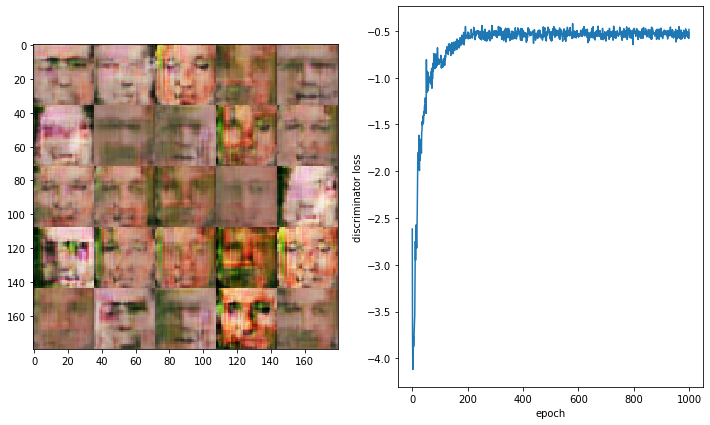

Done with epoch # 999


In [19]:
BATCH_SIZE = 256

N_EPOCHS = 1000
NUM_DISC_STEPS = 5

i_disc_step = 0
if not 'losses' in globals():
  losses = []
for i_ep in range(
    (i_ep + 1) if 'i_ep' in globals() else 0,
    N_EPOCHS
  ):
  shuffle_ids = np.random.choice(len(X_train), len(X_train), replace=False)
  epoch_loss = 0
  tf.keras.backend.set_learning_phase(1) # train
  for i_img in trange(0, len(X_train), BATCH_SIZE):
    batch = X_train[shuffle_ids][i_img:i_img + BATCH_SIZE]

    if i_disc_step < NUM_DISC_STEPS:
      # discriminator update
      i_disc_step += 1
      epoch_loss += disc_step(batch).numpy() * len(batch)
    else:
      i_disc_step = 0
      epoch_loss -= gen_step(batch).numpy() * len(batch)

  epoch_loss /= len(X_train)
  losses.append(epoch_loss)

  opt_d.learning_rate.assign(opt_d.learning_rate * 0.98)
  opt_g.learning_rate.assign(opt_g.learning_rate * 0.98)


  if i_ep % 5 == 0 or i_ep == N_EPOCHS - 1:
    imgs = (gen_images(25).numpy() * 255).astype('uint8')
    clear_output(wait=True)
    plt.figure(figsize=(12, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(imgs.reshape((5, 5, 36, 36, 3)).transpose(0, 2, 1, 3, 4).reshape(36 * 5, 36 * 5, 3))
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.xlabel('epoch')
    plt.ylabel('discriminator loss')
    plt.show()
  print("Done with epoch #", i_ep)

## Excersizes

### 1. Implement a GAN with convolutional layers

### 2. Implement a Wasserstein GAN